In [1]:
import os
import sys
sys.path.append('../../')
from utils import load_results_from_h5, save_results_to_h5, get_detected_SNRs
import numpy as np
from tqdm import tqdm
import pylab as plt

In [2]:
project_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study'
netw = 'LHI_Asharp'
#netw = 'CE4020ET123_CoBA10'
pop_num = 5
if pop_num == 2:
    pop_str = 'MD'
elif pop_num == 4:
    pop_str = 'MDhigh_zp_2.53'
elif pop_num == 5:
    pop_str = 'MDlow_zp_1.54'
fref_str = 'fref_10_'
#fref_str = ''
num_points_str = '24M'
extra_str = '_total'
study_label = f'{netw}_SNR_{pop_num}_pop_PLP_spin_prec_{fref_str}z_{pop_str}_zmax_10_lmrd_22_corrected_td'
inj_file = os.path.join(project_dir, 
                        'gwpopulation/BBH/injections/combined_h5_files_select_params', 
                        f'{study_label}_{num_points_str}_points_XPHM{extra_str}.h5')
inj_file


'/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulation/BBH/injections/combined_h5_files_select_params/LHI_Asharp_SNR_5_pop_PLP_spin_prec_fref_10_z_MDlow_zp_1.54_zmax_10_lmrd_22_corrected_td_24M_points_XPHM_total.h5'

In [3]:
inj_data = load_results_from_h5(inj_file)

In [4]:
for key in inj_data.keys():
    print(key)
    print(inj_data[key].keys())

total
dict_keys(['SNR_H1', 'SNR_I1', 'SNR_L1', 'SNR_mf_from_opt_H1', 'SNR_mf_from_opt_I1', 'SNR_mf_from_opt_L1', 'SNR_mf_from_opt_network', 'SNR_network', 'distance', 'redshift', 'srcmtotal'])


## Calculate mf SNR from gaussian distribution

In [5]:
def get_netw_mf_snr_from_gaussian(netw_optimal_snr):
    while True:
        mf_snr = np.random.normal(netw_optimal_snr, 1)
        if mf_snr > 0:
            return mf_snr

In [6]:
new_data = inj_data.copy()
new_data['total']['SNR_mf_from_gaussian_network'] = np.array([get_netw_mf_snr_from_gaussian(snr) for snr in tqdm(inj_data['total']['SNR_network'])])

  0%|          | 0/23999982 [00:00<?, ?it/s]

100%|██████████| 23999982/23999982 [00:24<00:00, 963546.34it/s] 


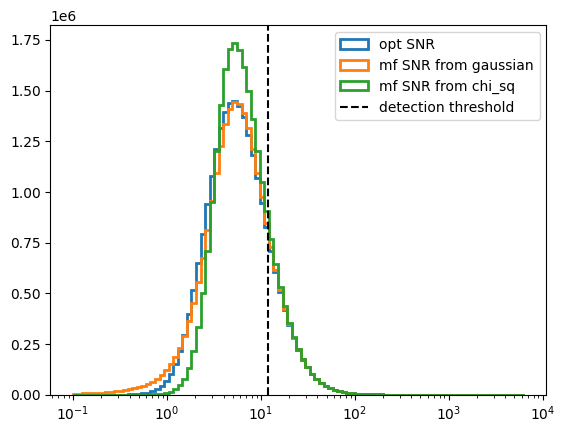

In [7]:
bins = np.logspace(-1, 3.8, 100)
plt.hist(new_data['total']['SNR_network'], label='opt SNR', histtype='step', lw=2, bins=bins)
plt.hist(new_data['total']['SNR_mf_from_gaussian_network'], label='mf SNR from gaussian', histtype='step', lw=2, bins=bins)
plt.hist(new_data['total']['SNR_mf_from_opt_network'], label='mf SNR from chi_sq', histtype='step', lw=2, bins=bins)
plt.xscale('log')
plt.axvline(12, color='k', ls='--', label='detection threshold')
plt.legend()

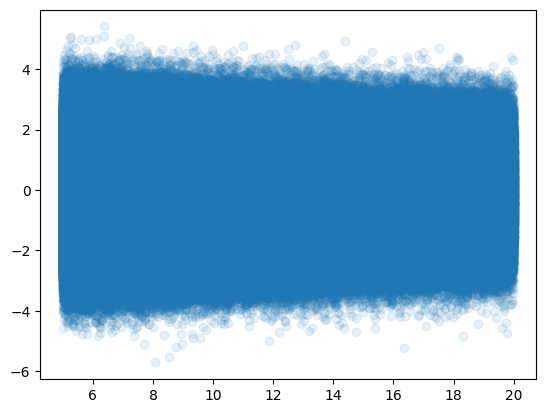

In [12]:
mask_5_20 = (new_data['total']['SNR_network'] > 5) & (new_data['total']['SNR_network'] < 20)
plt.plot(new_data['total']['SNR_network'][mask_5_20], 
         new_data['total']['SNR_mf_from_gaussian_network'][mask_5_20] - new_data['total']['SNR_network'][mask_5_20], 
         'o', alpha=0.1)

In [8]:
mask_opt_below_10 = new_data['total']['SNR_network'] < 10
mask_mf_above_12 = new_data['total']['SNR_mf_from_gaussian_network'] >= 12
out_of_bounds_perc = 100 * np.sum(mask_opt_below_10 & mask_mf_above_12) / len(new_data['total']['SNR_network'])
out_of_bounds_perc

0.03326669161668538

## Get detected population

In [9]:
new_data['detected_mf_from_gaussian'] = get_detected_SNRs(new_data['total'], 
                                                          method='network', snr_type='mf_from_gaussian')

['SNR_mf_from_gaussian_network']


In [10]:
#len(injected_data['detected']['redshift']), len(injected_data['detected_mf']['redshift']), len(injected_data['detected_mf_from_opt']['redshift'])
num_detected = len(new_data['detected_mf_from_gaussian']['redshift'])
print('Detected =', num_detected, f"({num_detected*100/len(new_data['total']['redshift']):.2f} %)")

Detected = 3930838 (16.38 %)


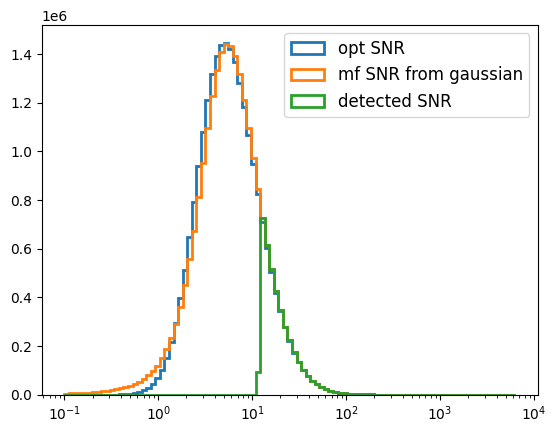

In [11]:
bins = np.logspace(-1, 3.8, 100)
plt.hist(new_data['total']['SNR_network'], label='opt SNR', histtype='step', lw=2, bins=bins)
plt.hist(new_data['total']['SNR_mf_from_gaussian_network'], label='mf SNR from gaussian', histtype='step', 
         lw=2, bins=bins)
plt.hist(new_data['detected_mf_from_gaussian']['SNR_mf_from_gaussian_network'], label='detected SNR', 
         histtype='step', lw=2, bins=bins)
plt.xscale('log')
#plt.axvline(12, color='k', ls='--', label='detection threshold')
plt.legend(fontsize=12)

## Create gwpopulation injection prior for redshift

In [12]:
MDhigh_params = {'gamma':2.7, 'kappa':5.6, 'z_peak':2.53}
MDlow_params = {'gamma':2.7, 'kappa':5.6, 'z_peak':1.54}
MD_params = {'gamma':2.7, 'kappa':5.6, 'z_peak':1.9}

In [13]:
if pop_num == 4:
    pop_params = MDhigh_params
    MDmodel = 'MDhigh'
elif pop_num == 5:
    pop_params = MDlow_params
    MDmodel = 'MDlow'
else:
    pop_params = MD_params

In [14]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
from GWForge.population.redshift import Redshift
z_max = 11
print(pop_params)
gwf_z = Redshift(redshift_model='MadauDickinson', 
                 local_merger_rate_density=22, 
                 maximum_redshift=z_max, 
                 gps_start_time=0, 
                 parameters=pop_params)
gwf_z_prob = gwf_z.coalescence_rate()

{'gamma': 2.7, 'kappa': 5.6, 'z_peak': 1.54}


Output()

In [15]:
import bilby
z_grid = np.arange(0, z_max, 0.001)
p_z = bilby.core.prior.Interped(z_grid, gwf_z_prob(z_grid))

In [16]:
new_data['detected_mf_from_gaussian']['p_z'] = p_z.probability_density(new_data['detected_mf_from_gaussian']['redshift'])

Text(0.5, 0, '$z$')

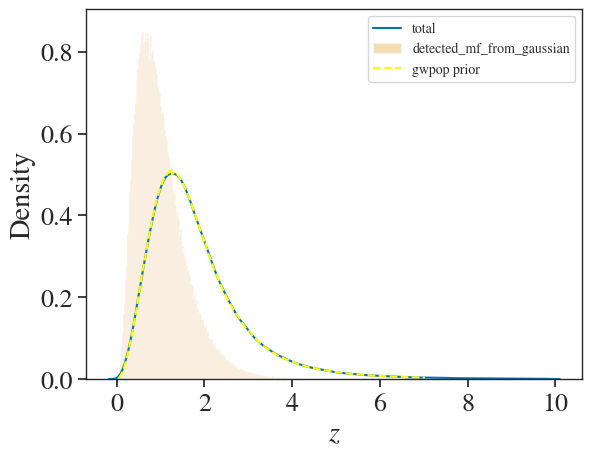

In [17]:
import seaborn as sns
npoints = int(1e6)
sns.kdeplot(new_data['total']['redshift'][:npoints], label='total')
plt.hist(new_data['detected_mf_from_gaussian']['redshift'][:npoints], label='detected_mf_from_gaussian', 
         bins=1000, alpha=0.3, density=True)
sort_idx_mf = np.argsort(new_data['detected_mf_from_gaussian']['redshift'][:npoints])
plt.plot(np.array(new_data['detected_mf_from_gaussian']['redshift'][:npoints])[sort_idx_mf], 
         np.array(new_data['detected_mf_from_gaussian']['p_z'][:npoints])[sort_idx_mf], 
         label='gwpop prior', ls='--', c='yellow')
plt.legend(loc=1, fontsize=10)
plt.xlabel('$z$')

## Write to file

### Write to .h5 file

In [18]:
inj_file

'/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulation/BBH/injections/combined_h5_files_select_params/LHI_Asharp_SNR_5_pop_PLP_spin_prec_fref_10_z_MDlow_zp_1.54_zmax_10_lmrd_22_corrected_td_24M_points_XPHM_total.h5'

In [19]:
inj_file_detected = inj_file.replace('total.h5', 'det_mf_from_gaussian.h5')
inj_file_detected

'/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulation/BBH/injections/combined_h5_files_select_params/LHI_Asharp_SNR_5_pop_PLP_spin_prec_fref_10_z_MDlow_zp_1.54_zmax_10_lmrd_22_corrected_td_24M_points_XPHM_det_mf_from_gaussian.h5'

In [20]:
save_results_to_h5(new_data, inj_file_detected)

### Write to pickle file

In [21]:
z_dict_write_mf_from_gaussian = {'redshift':np.array(new_data['detected_mf_from_gaussian']['redshift']), 
                            'prior':np.array(new_data['detected_mf_from_gaussian']['p_z']),
                            'total_generated':len(new_data['total']['redshift'])}

In [22]:
z_dict_write_mf_from_gaussian

{'redshift': array([0.6022689 , 1.55259071, 0.87166371, ..., 0.41323649, 1.5584957 ,
        0.29592415]),
 'prior': array([0.26908426, 0.46904464, 0.41923698, ..., 0.14544581, 0.46762345,
        0.08126441]),
 'total_generated': 23999982}

In [23]:
study_label

'LHI_Asharp_SNR_5_pop_PLP_spin_prec_fref_10_z_MDlow_zp_1.54_zmax_10_lmrd_22_corrected_td'

In [ ]:
out_file = os.path.join(project_dir, 'gwpopulation', 'BBH', 'injections', 
                        f'{study_label}_detected_injs_mf_from_gaussian_SNR_24M_points_XPHM.pkl')
out_file

'/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulation/BBH/injections/LHI_Asharp_SNR_5_pop_PLP_spin_prec_fref_10_z_MDlow_zp_1.54_zmax_10_lmrd_22_corrected_td_detected_injs_mf_from_gaussian_SNR_4M_points_XPHM.pkl'

In [25]:
import dill
with open(out_file, 'wb') as f:
    dill.dump(z_dict_write_mf_from_gaussian, f)